In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
m1="CIC-IDS-2017/Monday-WorkingHours.pcap_ISCX.csv"
t1="CIC-IDS-2017/Tuesday-WorkingHours.pcap_ISCX.csv"
w1="CIC-IDS-2017/Wednesday-workingHours.pcap_ISCX.csv"
th1="CIC-IDS-2017/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv"
th2="CIC-IDS-2017/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv"
f1="CIC-IDS-2017/Friday-WorkingHours-Morning.pcap_ISCX.csv"
f2="CIC-IDS-2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
f3="CIC-IDS-2017/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv"

dm1 = pd.read_csv(m1)
dt1 = pd.read_csv(t1)
dw1 = pd.read_csv(w1)
dth1 = pd.read_csv(th1)
dth2 = pd.read_csv(th2)
df1 = pd.read_csv(f1)
df2 = pd.read_csv(f2)
df3 = pd.read_csv(f3)

In [5]:
df = pd.concat([dm1,dt1,dw1,dth1,dth2,df1, df2, df3], axis=0)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()

In [7]:
print("Dataset info:\n", df.info())
print("Dataset description:\n", df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 2827876 entries, 0 to 286466
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max               

In [8]:
class_counts = df.iloc[:, -1].value_counts()
print("Class Counts:\n", class_counts)

Class Counts:
  Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [17]:
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

In [40]:
class_names=le.classes_

In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
class CICDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [22]:
y_train = y_train.to_numpy().flatten()
y_test = y_test.to_numpy().flatten()

In [23]:
batch_size = 64
train_dataset = CICDataset(X_train, y_train)
test_dataset = CICDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        return self.fc(x)

In [25]:
input_size = X_train.shape[1]
num_classes = len(np.unique(y))

model = NeuralNetwork(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {correct/total:.4f}")


Epoch 1/10, Loss: 2921.5187, Accuracy: 0.9688
Epoch 2/10, Loss: 2147.7910, Accuracy: 0.9754
Epoch 3/10, Loss: 2032.4286, Accuracy: 0.9769
Epoch 4/10, Loss: 2004.7723, Accuracy: 0.9780
Epoch 5/10, Loss: 1926.7339, Accuracy: 0.9789
Epoch 6/10, Loss: 2055.7382, Accuracy: 0.9799
Epoch 7/10, Loss: 1818.7593, Accuracy: 0.9810
Epoch 8/10, Loss: 1817.8341, Accuracy: 0.9811
Epoch 9/10, Loss: 1818.1065, Accuracy: 0.9812
Epoch 10/10, Loss: 1852.3158, Accuracy: 0.9807


In [1]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {correct/total:.4f}")

NameError: name 'model' is not defined

In [ ]:
torch.save(model.state_dict(), "models/pytorch_NeuralNetworkmodel.pth")
print("Model saved successfully.")

Model saved successfully.


In [ ]:
def evaluate_model(model, data_loader, device):
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    # Convert to NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Precision, Recall, F1 Score
    precision = precision_score(y_true, y_pred, average='weighted')  # Use 'weighted' for imbalanced datasets
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot Confusion Matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification Report
    print("\nClassification Report:\n", classification_report(y_true, y_pred,digits=4,target_names=class_names))

c:\Users\rishu\miniconda3\envs\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.9836
Recall: 0.9835
F1 Score: 0.9832


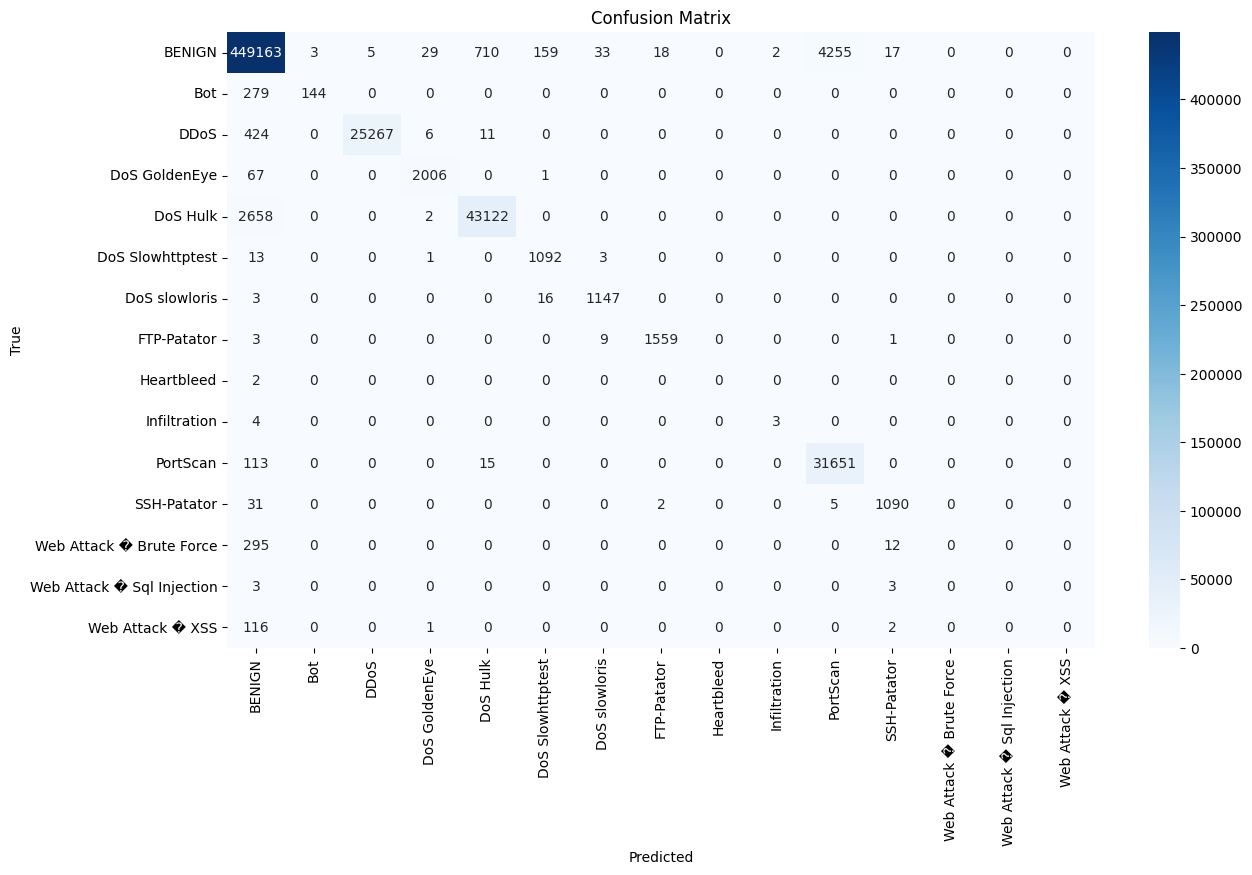


Classification Report:
                             precision    recall  f1-score   support

                    BENIGN     0.9911    0.9885    0.9898    454394
                       Bot     0.9796    0.3404    0.5053       423
                      DDoS     0.9998    0.9828    0.9913     25708
             DoS GoldenEye     0.9809    0.9672    0.9740      2074
                  DoS Hulk     0.9832    0.9419    0.9621     45782
          DoS Slowhttptest     0.8612    0.9847    0.9188      1109
             DoS slowloris     0.9622    0.9837    0.9729      1166
               FTP-Patator     0.9873    0.9917    0.9895      1572
                Heartbleed     0.0000    0.0000    0.0000         2
              Infiltration     0.6000    0.4286    0.5000         7
                  PortScan     0.8814    0.9960    0.9352     31779
               SSH-Patator     0.9689    0.9663    0.9676      1128
  Web Attack � Brute Force     0.0000    0.0000    0.0000       307
Web Attack � Sql Injec

c:\Users\rishu\miniconda3\envs\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rishu\miniconda3\envs\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rishu\miniconda3\envs\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [46]:
evaluate_model(model, test_loader, device)